In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import itertools

from sklearn.preprocessing import StandardScaler

In [2]:
# Global vars;

V = 441
SM_SIZE = 21

# Q1

# Functions

In [3]:
# Generate a TC source;

# AV:       arrival vector;
# IV:       interval vector;
# duration: duration vector;
# idx:      position of input parameters to use;
# n:        number of samples in TC;

def generate_tc(av, iv, dur, idx, n):
    _N = n
    _arrival = av[idx]  # Arrival of first batch;
    _increment = iv[idx]  # Interval to future batch;
    _duration = dur[idx]  # Duration of ones;
    
    values = []  # Array of values to return;
    
    # ====================
    # Pre-calculate all the index positions so we can fill in 1s and 0s accordingly;
    
    # Get position of each batch;
    _batches = [_arrival + (_increment * x) 
                for x in range(1, int((_N-_arrival)/_increment)+1)]
    
    # Get position of each end of ones;
    _ones_ends = [n + _duration for n in _batches]                                                                                                   
    
    
    # ====================
    # First, fill any pre-arrival zeros;
    for i in range(0, _arrival):
        values.append(0)
        
    # Then, fill the batches;
    _val = 1
    for i in range(_arrival, _N):
        
        # If this value is at the start of a batch, make it 1;
        if (i in _batches):
            _val = 1
            #print("batch start: " + str(i))
            
        # If this value is after the end of ones, make it 0;
        if (i == _arrival + _duration or i in _ones_ends):
            _val = 0
            #print("ones end: " + str(i))
            
        # Append this value to output;
        values.append(_val)
        
    return values

In [4]:
# Generate and get an array of TC sources;

# AV:       arrival vector;
# IV:       interval vector;
# duration: duration vector;
# total:    number of TCs to make (i.e. length of vectors);
# n:        number of samples in each TC;

def get_tcs(AV, IV, duration, total, n):  
    tc_list = []  
    for i in range(0, total):
        _tc = generate_tc(AV, IV, duration, i, n)
        tc_list.append(_tc)     
    return tc_list

In [5]:
# Standardize values;

# values: array of input values;

def standardize_values(values):
    z = (values - np.mean(values)) / np.std(values)
    return z

# Construct TC

In [6]:
AV = [0,20,0,0,0,0]
IV = [30,45,60,40,40,40]
duration = [15,20,25,15,20,25]

In [7]:
tcs = get_tcs(AV, IV, duration, 6, 240)

In [8]:
# Standardize all TCs

tcs_standardized = [standardize_values(tc) for tc in tcs]

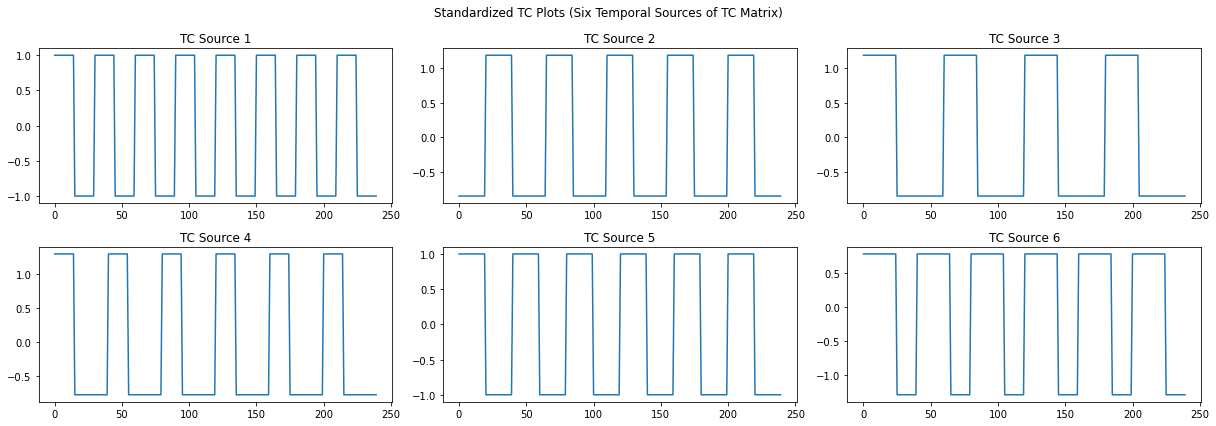

In [89]:
# Plot all 6 standardized TCs;

fig, axes = plt.subplots(2, 3, figsize=(17,6))

fig.suptitle('Standardized TC Plots (Six Temporal Sources of TC Matrix)')

for i in range(0, 2):
    for j in range(0, 3):
        idx = i+j
        if(i!=0):
            idx += i+1
            
        tc = tcs_standardized[idx]
        sns.lineplot(data=tc, ax=axes[i,j])
        axes[i, j].set_title("TC Source " + str(idx+1))
        
fig.tight_layout()
plt.show()

In [90]:
# Construct matrix TC;

TC_df = pd.DataFrame(tcs_standardized).T

In [91]:
TC_corr = TC_df.corr()

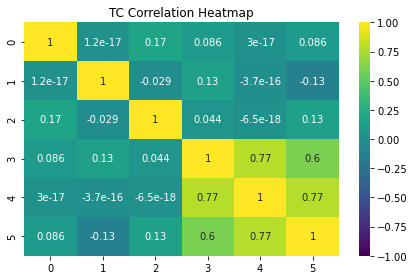

In [92]:
# Correlation heatmap;
fig = sns.heatmap(TC_corr, annot=True, 
                  vmin=-1, vmax=1, center=0, cmap="viridis")
fig.set_title("TC Correlation Heatmap")
plt.tight_layout()
plt.show()

In [93]:
# TC sources 3, 4, 5 are highly correlated;

# Construct tmpSM Array

In [94]:
# Create tmpSM array of six 21x21 SMs;
# For each SM, put ones at specified (vertical, horizontal) positions;

# Define ranges;
ones_ranges = [
    ((2,6),(2,6)),
    ((2,6),(15,19)),
    ((8,13),(2,6)),
    ((8,13),(15,19)),
    ((15,19),(2,6)),
    ((15,19),(15,19))]

# Initialize tmpSM;
initSM = []
for n in range(0,6):
    sm = np.zeros((21, 21))
    ranges = ones_ranges[n]
    vertical_range = range(ranges[0][0]-1, ranges[0][1])
    horizontal_range = range(ranges[1][0]-1, ranges[1][1])
    
    for i in vertical_range:
        for j in horizontal_range:
            sm[i][j] = 1
    
    initSM.append(sm)

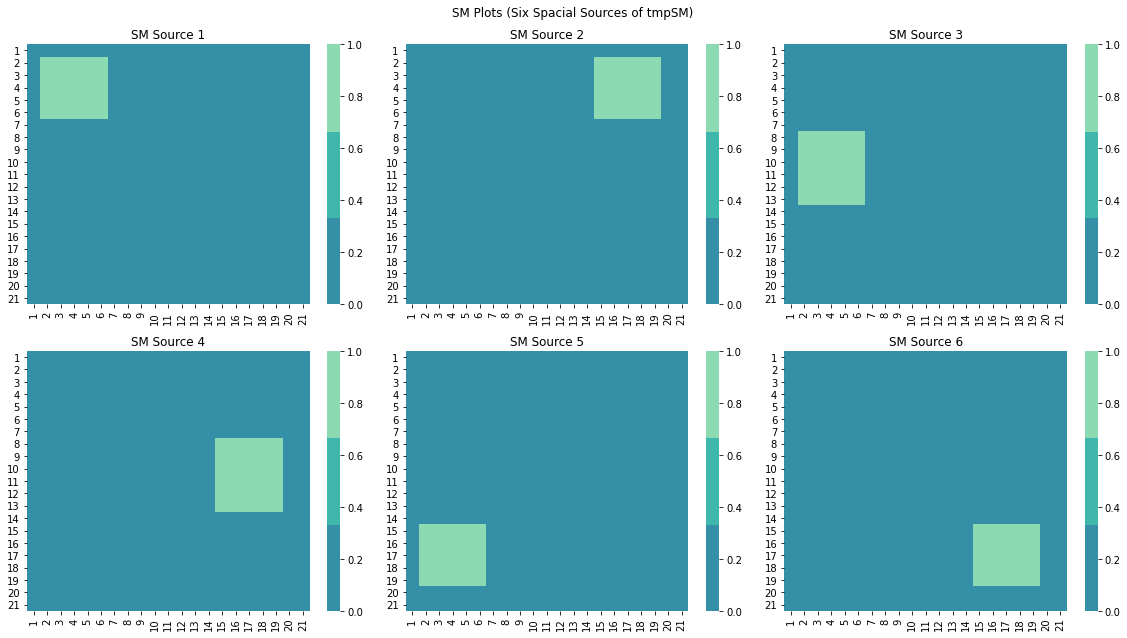

In [95]:
# Plot each SM;

tmpSM = initSM

fig, axes = plt.subplots(2, 3, figsize=(16,9))

fig.suptitle('SM Plots (Six Spacial Sources of tmpSM)')

for i in range(0, 2):
    for j in range(0, 3):
        idx = i+j
        if(i!=0):
            idx += i+1
        sm = tmpSM[idx]
        sns.heatmap(data=sm, cmap=sns.color_palette("mako"),
                    xticklabels=list(range(1,22)),
                    yticklabels=list(range(1,22)),
                    vmin=0, vmax=1, center=0, ax=axes[i,j])
        axes[i, j].set_title("SM Source " + str(idx+1))
            
fig.tight_layout()
plt.show()

In [177]:
# Reshape each SM source into 1 * 441 matrix;
# Then combine into 6 * 441 matrix;


# Reshape each SM source, transpose first to keep columns;
SM = [sm.transpose().reshape(1,441) for sm in tmpSM] 

# Combine SM sources;
SM = np.stack(SM)

# Remove innermost nesting;
SM = [list(itertools.chain(*nested)) for nested in SM]

In [156]:
SM_df = pd.DataFrame(SM)

In [157]:
SM_corr = SM_df.T.corr()

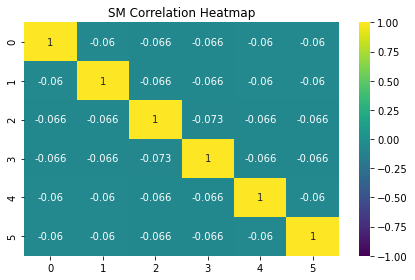

In [158]:
# Correlation heatmap;
fig = sns.heatmap(SM_corr, annot=True, 
                  vmin=-1, vmax=1, center=0, cmap="viridis")
fig.set_title("SM Correlation Heatmap")
plt.tight_layout()
plt.show()

# Generate Zero Mean White Gaussian Noise

In [159]:
# Noise for TC: 240 rows * 6 columns;
# Variance: 0.25;

noise_t = np.random.normal(0, np.sqrt(0.25), (240,6))
noise_t = pd.DataFrame(noise_t)


# Noise for SM: 6 rows * 441 columns;
# Variance: 0.015

noise_s = np.random.normal(0, np.sqrt(0.015), (6, 441))
noise_s = pd.DataFrame(noise_s)

In [160]:
noise_t_corr = noise_t.corr()
noise_s_corr = noise_s.T.corr()

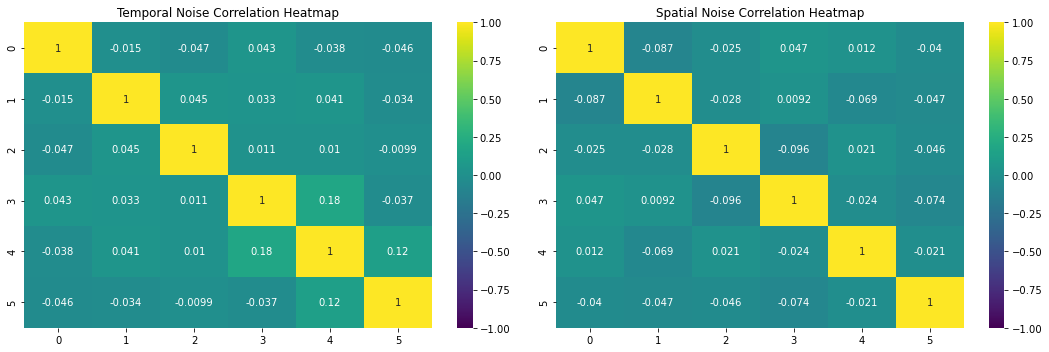

In [161]:
# Correlation heatmaps for temporal and spatial noise sources;

fig, axes = plt.subplots(1, 2, figsize=(15,5))

sns.heatmap(noise_t_corr, annot=True, 
                  vmin=-1, vmax=1, center=0, cmap="viridis", ax=axes[0])
axes[0].set_title("Temporal Noise Correlation Heatmap")

sns.heatmap(noise_s_corr, annot=True, 
                  vmin=-1, vmax=1, center=0, cmap="viridis", ax=axes[1])
axes[1].set_title("Spatial Noise Correlation Heatmap")

fig.tight_layout()
plt.show()

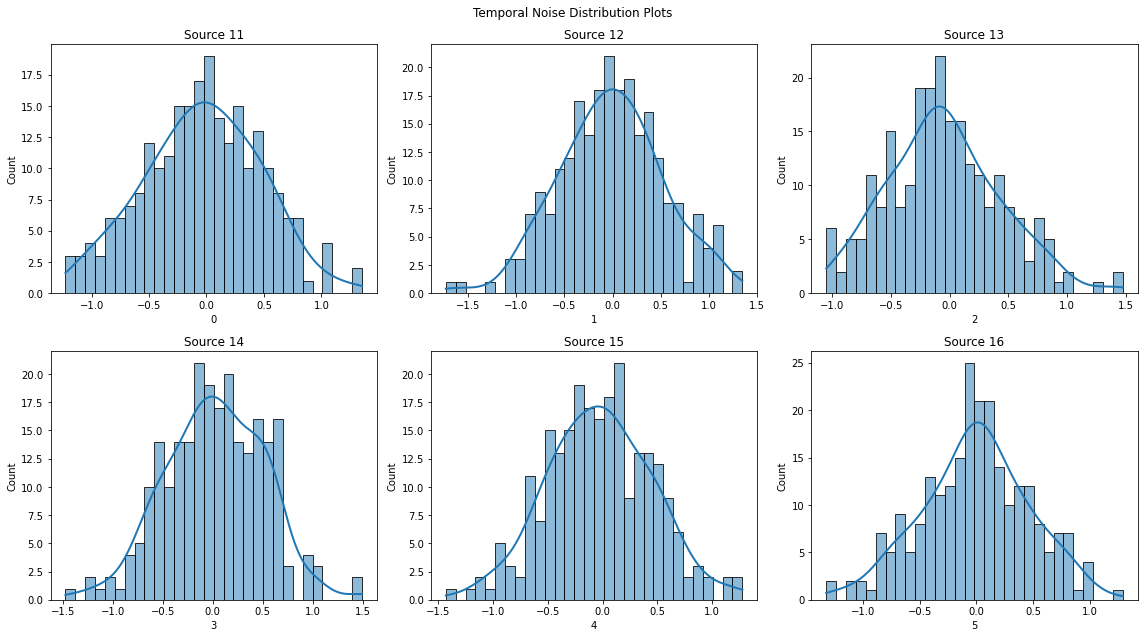

In [162]:
# Distribution histograms of temporal and spatial noise sources;
fig, axes = plt.subplots(2, 3, figsize=(16,9))

fig.suptitle('Temporal Noise Distribution Plots')

for i in range(0, 2):
    for j in range(0, 3):
        idx = i+j
        if(i!=0):
            idx += i+1
        sm = tmpSM[idx]
        sns.histplot(ax=axes[i,j], data=noise_t[idx], bins=30,
             kde=True,
             line_kws={"linewidth":2})
        axes[i, j].set_title("Source 1" + str(idx+1))
    
fig.tight_layout()
plt.show()

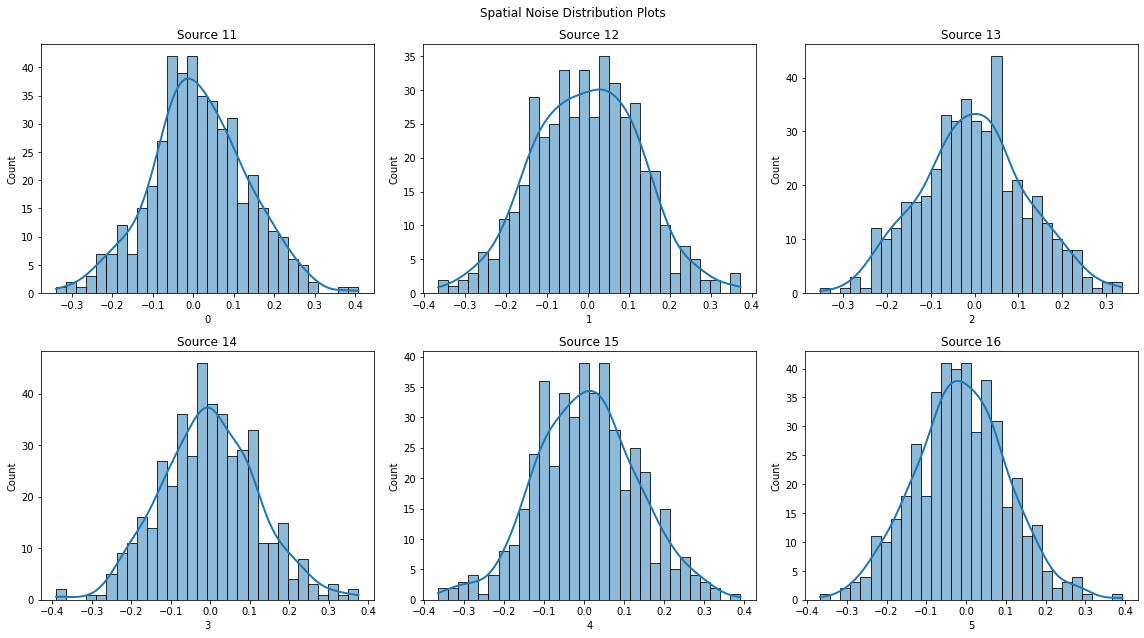

In [163]:
fig, axes = plt.subplots(2, 3, figsize=(16,9))

fig.suptitle('Spatial Noise Distribution Plots')

for i in range(0, 2):
    for j in range(0, 3):
        idx = i+j
        if(i!=0):
            idx += i+1
        sm = tmpSM[idx]
        sns.histplot(ax=axes[i,j], data=noise_s.T[idx], bins=30,
             kde=True,
             line_kws={"linewidth":2})
        axes[i, j].set_title("Source 1" + str(idx+1))
        
fig.tight_layout()
plt.show()

# Generate Synthetic Dataset

In [164]:
# Use numpy 2D-arrays for matrix operations.

TC = TC_df.values
Gt = noise_t.values
SM = SM_df.values
Gs = noise_s.values

X_init = np.dot((TC+Gt), (SM+Gs))

# Use df for visualizing;
X_init_df = pd.DataFrame(X_init)

In [165]:
X_subset_df = X_init_df.sample(n=5,axis='columns', random_state = 353)

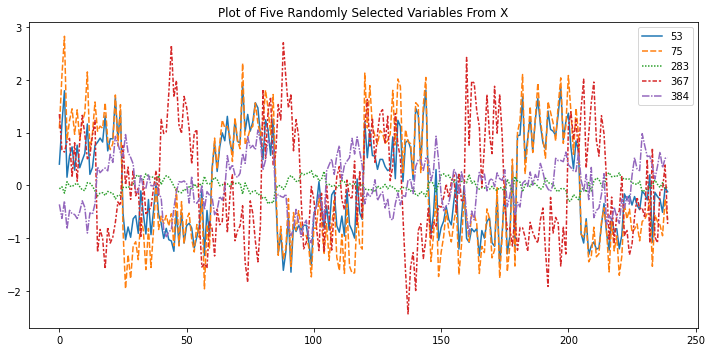

In [166]:
# Plot randomly selected variables (columns) from X;

fig, axes = plt.subplots(figsize=(10,5))

sns.lineplot(data=X_subset_df, )
axes.set_title("Plot of Five Randomly Selected Variables From X")


plt.tight_layout()
plt.show()

In [167]:
X_stats_df = pd.DataFrame()
X_stats_df["variance"] = X_init_df.var()

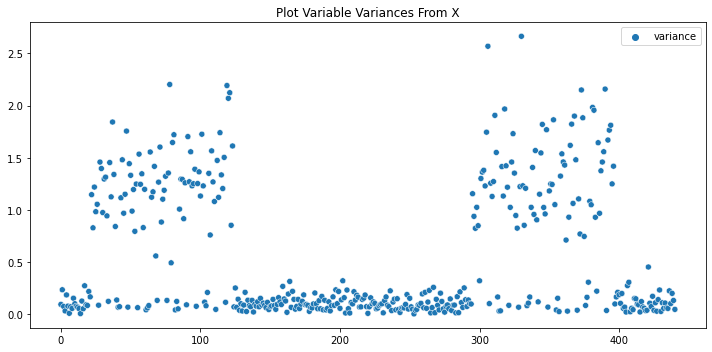

In [168]:
# Plot variance of each of the 441 variables (columns) from X;

fig, axes = plt.subplots(figsize=(10,5))

sns.scatterplot(data=X_stats_df)
axes.set_title("Plot Variable Variances From X")


plt.tight_layout()
plt.show()

In [169]:
X_standardized_df = pd.DataFrame(standardize_values(X_init_df[col]) for col in X_init_df).T

# Q2

In [170]:
# Using generated X_standardized;
# This dataset follows X = DA + E;

X = X_standardized_df.values
D = TC

In [171]:
# Estimate A_lsr;
# A_lsr = inv(DtD) %*% DtX;

DtD = np.dot(D.transpose(), D)

DtX = np.dot(D.transpose(), X)

A_lsr = np.dot(np.linalg.pinv(DtD), DtX)

# Retrieve D_lsr using A_lsr;
# D_lsr = X %*% t(A_lsr)

D_lsr = np.dot(X, A_lsr.transpose())

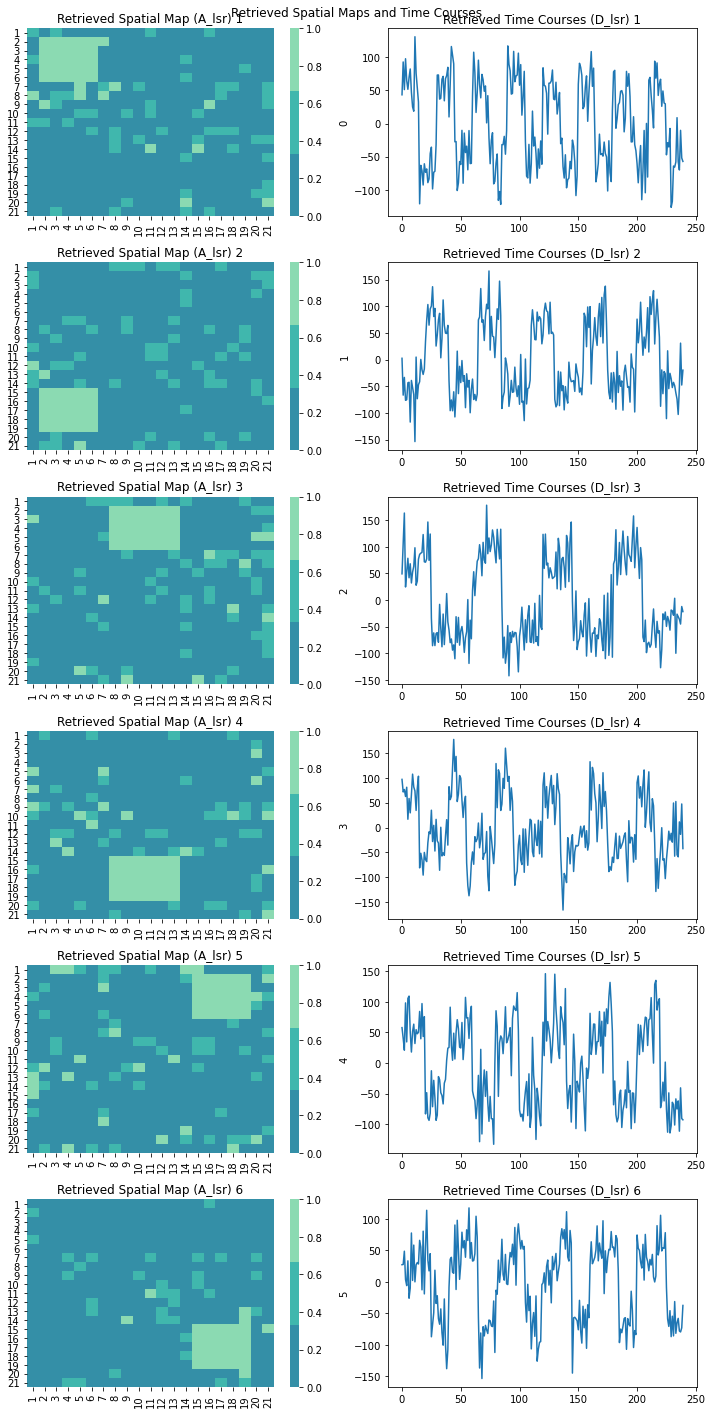

In [172]:
D_lsr_df = pd.DataFrame(D_lsr)

# Plot retrieced A_lsr and D_lsr for six sources;

fig, axes = plt.subplots(6, 2, figsize=(10,20))

fig.suptitle('Retrieved Spatial Maps and Time Courses')

# For each source;
for i in range(0, 6):
    idx = i
    
    # Get corresponding 21 * 21 sm source from A_lsr;
    sm_idx = int(21*(idx+1))
    A_lsr_sm = A_lsr.reshape(126,21)[sm_idx-21:sm_idx,:]

    # Plot A_lsr;
    sns.heatmap(data=A_lsr_sm, cmap=sns.color_palette("mako"),
                xticklabels=list(range(1,22)),
                yticklabels=list(range(1,22)),
                vmin=0, vmax=1, center=0, ax=axes[i, 0])
    axes[i, 0].set_title("Retrieved Spatial Map (A_lsr) " + str(idx+1))
    
    # Plot D_lsr;
    sns.lineplot(data=D_lsr_df[idx], ax=axes[i, 1])
    axes[i, 1].set_title("Retrieved Time Courses (D_lsr) " + str(idx+1))
    
        
fig.tight_layout()
plt.show()

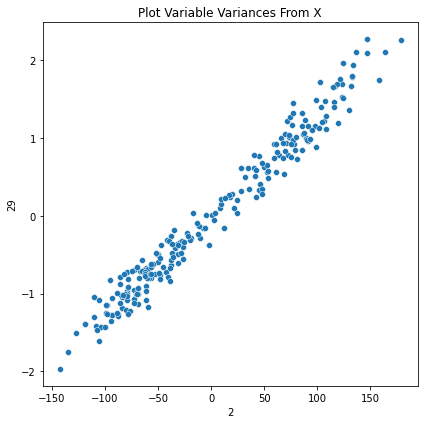

In [180]:
# Plot variance of each of the 441 variables (columns) from X;

fig, axes = plt.subplots(figsize=(6,6))

sns.scatterplot(x=D_lsr_df[2], y=X_standardized_df[29])
axes.set_title("Plot Variable Variances From X")
# plt.ylim(-5,5)

plt.tight_layout()
plt.show()

# Estimate RR Parameters

In [181]:
# Penalty parameter;
lambda_hat = 1 * V

# A_rr = inv(DtD + lambda_hat*I) %*% DtX;
A_rr = np.dot(np.linalg.pinv(DtD + lambda_hat * np.identity(6)), DtX)

# D_rr = X %*% t(A_rr);
D_rr = np.dot(X, A_rr.transpose())

In [182]:
D_lsr_df = pd.DataFrame(D_lsr)
D_rr_df = pd.DataFrame(D_rr)

In [183]:
# For each TC column, get its correlation with each D_lsr column;
for col in TC_df:
    for i in D_lsr_df:
        corr = D_lsr_df[i].corr(TC_df[col])
        #print(corr)

In [184]:
# columns: D_lsr;
# rows: TC;

c_tlsr_df = pd.concat([TC_df, D_lsr_df], axis=1).corr()\
                    .iloc[0:6,6:12].reset_index(drop=True)
c_tlsr = np.diag(c_tlsr_df)


In [185]:
c_trr_df = pd.concat([TC_df, D_rr_df], axis=1).corr()\
                    .iloc[0:6,6:12].reset_index(drop=True)
c_trr = np.diag(c_trr_df)

In [186]:
sum_c_tlsr = sum(c_tlsr)
sum_c_trr = sum(c_trr)
print("Sum of c_tlsr: " + str(sum_c_tlsr))
print("Sum of c_trr: " + str(sum_c_trr))

print("Sum of c_trr > Sum of c_tlsr: ")
print(sum_c_trr > sum_c_tlsr)

Sum of c_tlsr: 5.151101170860649
Sum of c_trr: 5.387505312428814
Sum of c_trr > Sum of c_tlsr: 
True


### Plots for A_lsr and A_rr

In [187]:
A_lsr_df = pd.DataFrame(A_lsr)
A_rr_df = pd.DataFrame(A_rr)

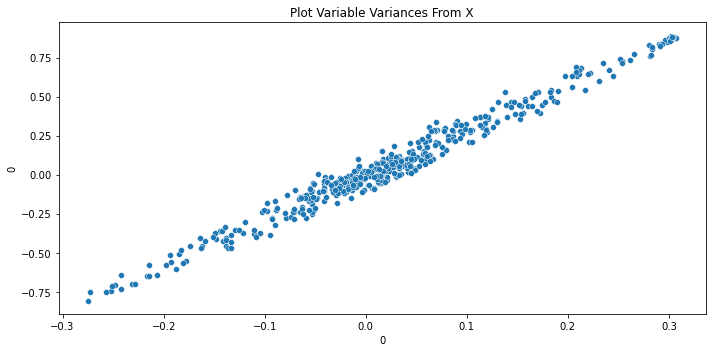

In [188]:
# Plot variance of each of the 441 variables (columns) from X;

fig, axes = plt.subplots(figsize=(10,5))

sns.scatterplot(x=A_rr_df.T[0], y=A_lsr_df.T[0])
axes.set_title("Plot Variable Variances From X")
# plt.ylim(-5,5)

plt.tight_layout()
plt.show()